In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("..")
from src.dataset import CRKPTransmissionSimulator
from src.approx_bc import abc_rejection_sampler

from scipy.stats import norm

In [2]:
path = "/Volumes/umms-esnitkin/Project_KPC_LTACH/Analysis/LTACH_transmission_modeling/preprocessed"

# Homogeneous Version

In [3]:
prior_mu = -2
prior_sigma = 1
# summarize = False
het=False
model = CRKPTransmissionSimulator(path, prior_mu, prior_sigma, heterogeneous=het

x_o = model.get_observed_data()

In [4]:
prior_sampler = lambda: model.sample_logbeta(1)
simulator = lambda theta, seed: model.CRKP_simulator(theta, seed)

In [12]:
S = 100
epsilon = 50
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=10000,
    summarize=summarize
)

Time lapsed: 30.01 seconds
With tolerance 50, acceptance rate: 0.030166
Total number of attempts: 3,315


#### posterior predictive check

In [14]:
np.exp(posterior_sample).mean()

0.16161509

#### View I: Total Infections over Time

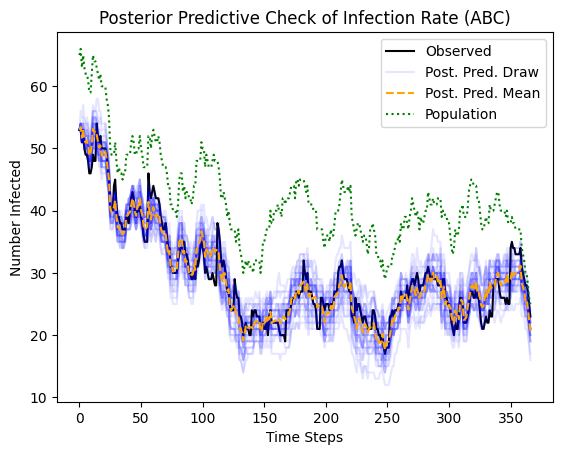

In [62]:
K = 30
Nt = model.W.sum(0)
posterior_predictive_abc = np.empty((K, model.T))
for i in range(30):
    beta = posterior_sample[i]
    x_rep = model.CRKP_simulator(beta, i)
    posterior_predictive_abc[i] =  np.array(x_rep) * model.N
pp_mean_abc = posterior_predictive_abc.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = x_o * model.N
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.plot(Nt, label="Population", color="g", linestyle=":")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Number Infected")
plt.xlabel("Time Steps")
plt.show()

#### View II: Novel Infections Only

In [26]:
precols = np.array(model.CRKP_simulator(-10, 1) * model.N)

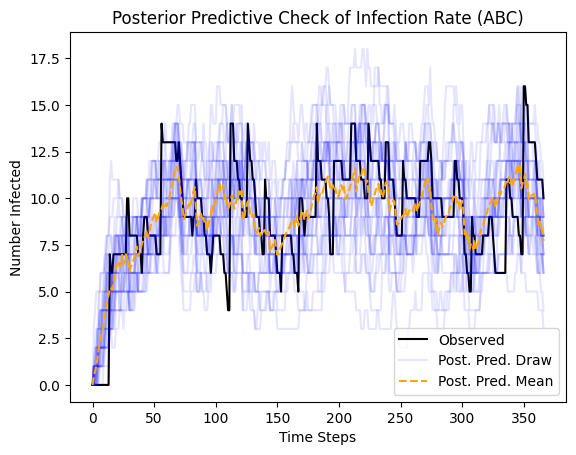

In [73]:
posterior_predictive_abc = np.empty((K, model.T))
for i in range(30):
    beta = posterior_sample[i]
    x_rep = model.CRKP_simulator(beta, i)
    posterior_predictive_abc[i] =  np.array(x_rep) * model.N - precols
pp_mean_abc = posterior_predictive_abc.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = x_o[:, 0] * model.N - precols
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# plt.plot(Nt, label="Population", color="g", linestyle=":")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Number Infected")
plt.xlabel("Time Steps")
plt.show()

#### View 3: Proportion Infected Over Time

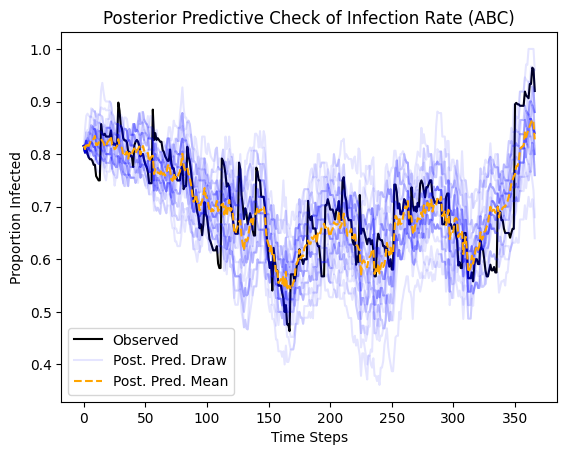

In [48]:
posterior_predictive_abc = np.empty((K, model.T))
for i in range(30):
    beta = posterior_sample[i]
    x_rep = model.CRKP_simulator(beta, i)
    posterior_predictive_abc[i] =  np.array(x_rep) * model.N / Nt
pp_mean_abc = posterior_predictive_abc.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = x_o[:, 0] * model.N / Nt
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive_abc.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean_abc, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
plt.title("Posterior Predictive Check of Infection Rate (ABC)")
plt.ylabel("Proportion Infected")
plt.xlabel("Time Steps")
plt.show()

# Heterogeneous

In [3]:
prior_mu = np.array([-3] + [-2 for _ in range(7)])
prior_sigma = np.array([1 for _ in range(8)])
summarize = False
het=True
model = CRKPTransmissionSimulator(path, prior_mu, prior_sigma, heterogeneous=het)

x_o = model.get_observed_data()

In [4]:
prior_sampler = lambda: model.sample_logbeta(1)
simulator = lambda theta, seed: model.CRKP_simulator(theta, seed)

In [5]:
test_errors = []
for t in range(100):
    theta = np.array(prior_sampler())[0]
    x = simulator(theta, seed=t)
    test_errors.append(np.linalg.norm(x - x_o, axis=1))

test_errors = np.stack(test_errors).mean(0)
lam = test_errors[0] / test_errors

In [20]:
S = 100
epsilon = 26
posterior_sample, errors = abc_rejection_sampler(
    S, epsilon, prior_sampler, simulator, x_o, max_attempts=10000,
    summarize=summarize, error_scaling=lam / 8
)

Time lapsed: 145.35 seconds
With tolerance 26, acceptance rate: 0.054765
Total number of attempts: 1,826


In [21]:
np.exp(posterior_sample).mean(0)

array([0.07084218, 0.29558697, 0.18226302, 0.40528947, 0.2555016 ,
       0.2464285 , 0.2847833 , 0.23126698], dtype=float32)

In [17]:
np.exp(prior_mu)

array([0.04978707, 0.13533528, 0.13533528, 0.13533528, 0.13533528,
       0.13533528, 0.13533528, 0.13533528])

In [23]:
np.exp(posterior_sample).std(0)

array([0.03610349, 0.30489796, 0.18363263, 0.32443437, 0.26397285,
       0.26746693, 0.35615316, 0.28993505], dtype=float32)

## NPE

In [87]:
np.exp(mu + sigma**2 / 2)

0.15737842870629867

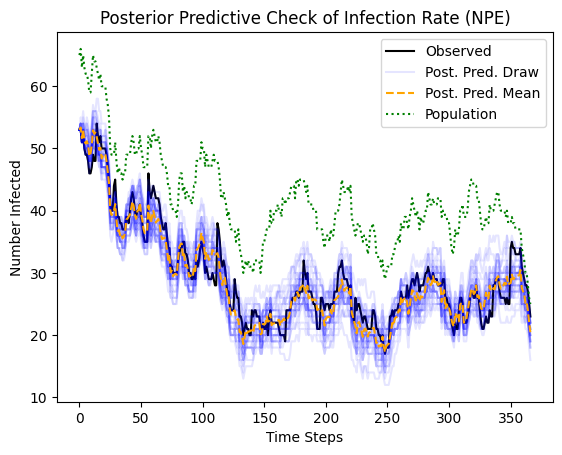

In [68]:
mu = -1.872
sigma = .214
neural_posterior = norm(mu, sigma)
npe_sample = neural_posterior.rvs(size=K, random_state=2)
posterior_predictive = np.empty((K, model.T))
for i in range(30):
    beta = npe_sample[i]
    x_rep = model.CRKP_simulator(beta, i)
    posterior_predictive[i] =  np.array(x_rep) * model.N
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = x_o * model.N
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.plot(Nt, label="Population", color="g", linestyle=":")
plt.legend()
plt.ylabel("Number Infected")
plt.xlabel("Time Steps")
plt.show()

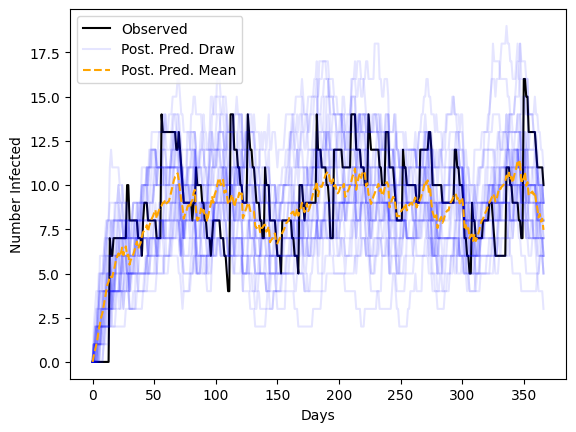

In [88]:
posterior_predictive_abc = np.empty((K, model.T))
for i in range(30):
    beta = npe_sample[i]
    x_rep = model.CRKP_simulator(beta, i)
    posterior_predictive[i] =  np.array(x_rep) * model.N - precols
pp_mean = posterior_predictive.mean(0)
labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = x_o[:, 0] * model.N - precols
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
# plt.plot(Nt, label="Population", color="g", linestyle=":")
plt.legend()
# plt.title("Posterior Predictive Check of Infection Rate")
plt.ylabel("Number Infected")
plt.xlabel("Days")
plt.show()

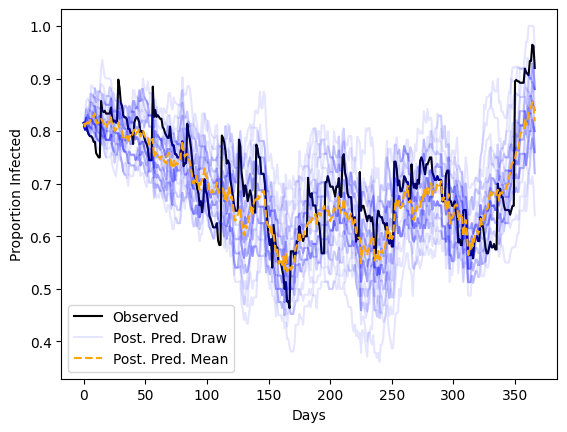

In [85]:
posterior_predictive = np.empty((K, model.T))
for i in range(30):
    beta = npe_sample[i]
    x_rep = model.CRKP_simulator(beta, i)
    posterior_predictive[i] =  np.array(x_rep) * model.N / Nt
pp_mean = posterior_predictive.mean(0)

labels = ["Post. Pred. Draw"] + [None for _ in range(K-1)]
I_o = x_o[:, 0] * model.N / Nt
plt.plot(I_o, label="Observed", color="k")
plt.plot(posterior_predictive.T, 
         label=labels, color="b",
         alpha=0.1)
plt.plot(pp_mean, label="Post. Pred. Mean", linestyle="--",
         color="orange")
plt.legend()
# plt.title("Posterior Predictive Check of Infection Rate")
plt.ylabel("Proportion Infected")
plt.xlabel("Days")
plt.show()

In [79]:
np.exp(neural_posterior.ppf(0.1)), np.exp(neural_posterior.ppf(0.9))

(0.11692155548041781, 0.20235170838488703)